In [ ]:
!python setup.py install

In [1]:
import os
import json
import numpy as np
import skimage.draw
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import skimage
import matplotlib.pyplot as plt

In [2]:
class_names = ['BG', 'persona']
real_test_dir = '../semanticSegmentation/dataset/persona/val'
min_confidence = 0.6

class PersonaConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "persona"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (persona)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = PersonaConfig()
config.display()

class InferenceConfig(PersonaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = min_confidence
    

inference_config = InferenceConfig()



Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [3]:
class PersonaDataset(utils.Dataset):

    def load_personas(self, dataset_dir, subset):
        """Load a subset of the persona dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("persona", 1, "persona")

        # Train or validation dataset?
        assert subset in ["train", "val",'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "persona",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a persona dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "persona":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "persona":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [4]:
model_filename = "persona20230311T2329/mask_rcnn_persona_0050.h5"
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir='logs')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join('logs', model_filename)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from  logs\persona20230311T2329/mask_rcnn_persona_0050.h5
Re-starting from epoch 50


In [5]:

def IoU_function(mask_real, mask_results,plot_results=True):
    
    annotation_mask = np.zeros((mask_real.shape[0], mask.shape[1]))
    for i in range(mask_real.shape[2]):
        annotation_mask = np.logical_or(annotation_mask, mask_real[:,:,i])
        #plt.imshow(annotation_mask,cmap='binary')
        #plt.show()
        
    result_mask = np.zeros((mask_results.shape[0], mask_results.shape[1]))
    for i in range(r['masks'].shape[2]):
        result_mask = np.logical_or(result_mask, mask_results[:,:,i])
        #plt.imshow(result_mask, cmap='binary')
        #plt.show()
    
    if(plot_results):
        plt.title('Annotation Mask')
        plt.imshow(annotation_mask,cmap='binary')
        plt.show()
     
        plt.title('Result Mask')
        plt.imshow(result_mask, cmap='binary')
        plt.show()
        
    intersection = np.logical_and(annotation_mask, result_mask)
    union = np.logical_or(annotation_mask, result_mask)
    
    IoU = np.sum(intersection) / np.sum(union)
    
    if(plot_results):
        colors = visualize.random_colors(2)
        IoU_image = visualize.apply_mask(image, intersection,(1.0, 0.0, 0.0), alpha=0.8)
        IoU_image = visualize.apply_mask(IoU_image, union, (0.0, 1.0, 0.0), alpha=0.3)
        plt.figure(figsize = (10,10))
        plt.text(20, 30, 'Union',bbox=dict(facecolor='green', alpha=0.5))
        plt.text(20, 50, 'Intersection',bbox=dict(facecolor='red', alpha=0.5))
        plt.title('IoU Image - Intersection over Union')
        plt.imshow(IoU_image)
        plt.show()

    return IoU;


Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


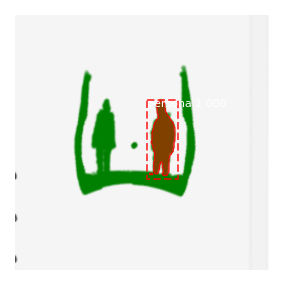

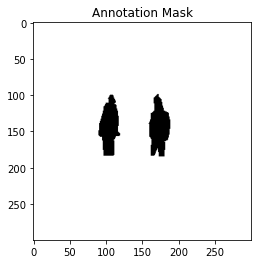

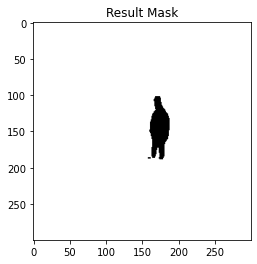

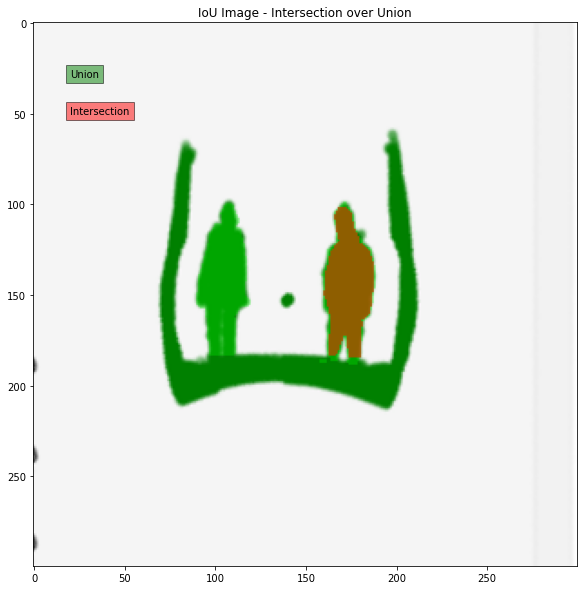

IoU: 0.45643770443056797
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


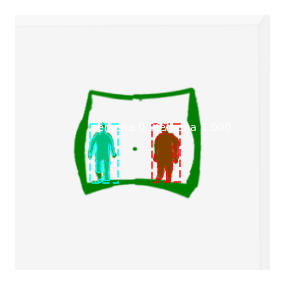

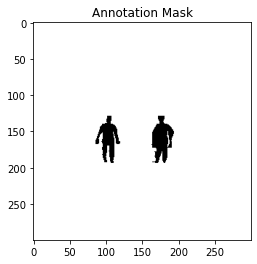

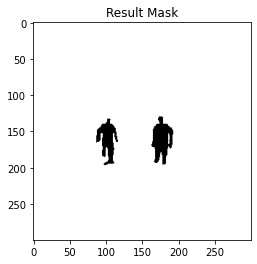

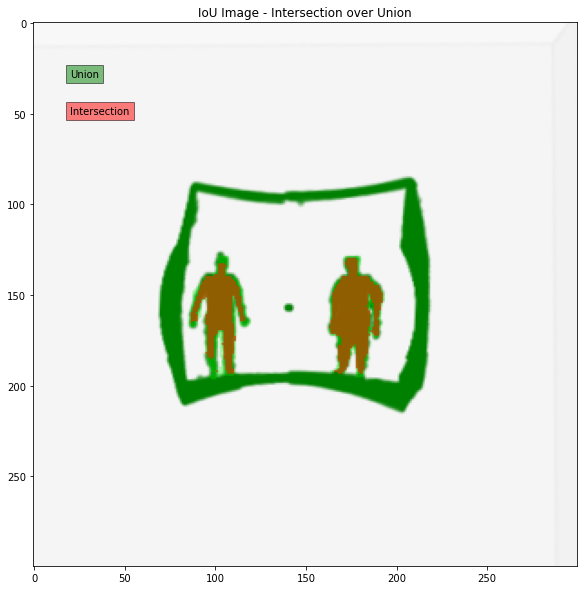

IoU: 0.7825732899022801
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


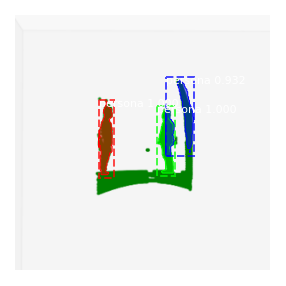

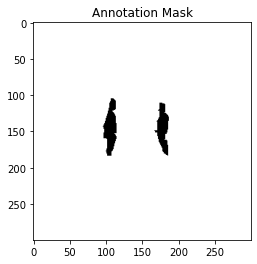

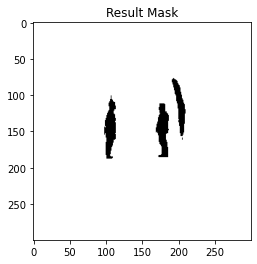

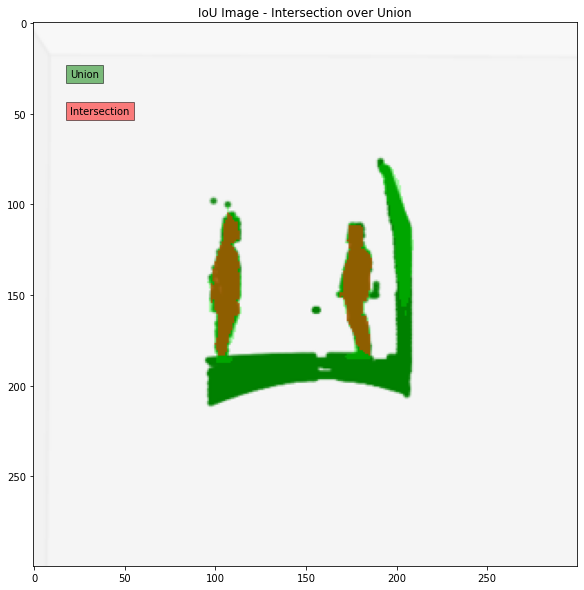

IoU: 0.6065573770491803
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


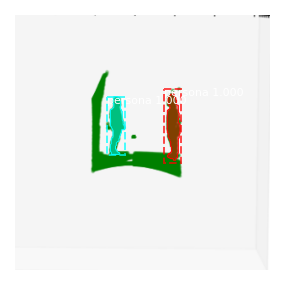

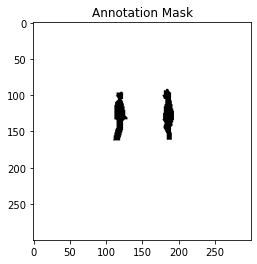

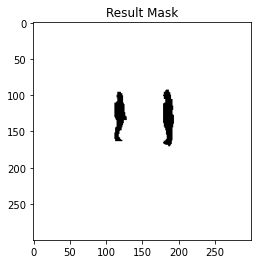

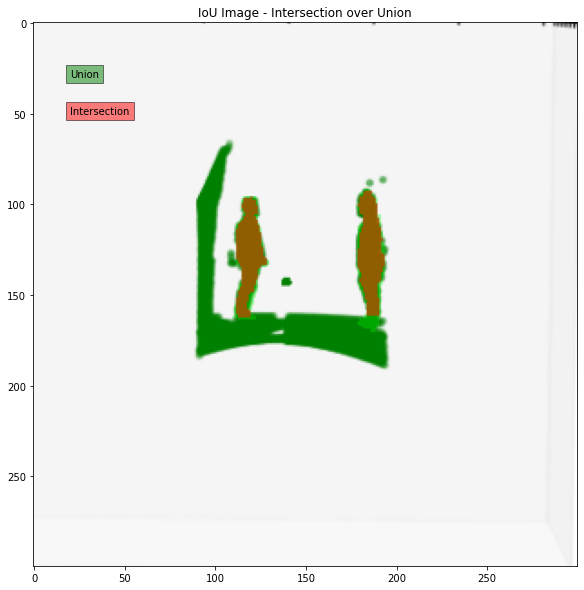

IoU: 0.809863339275104
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


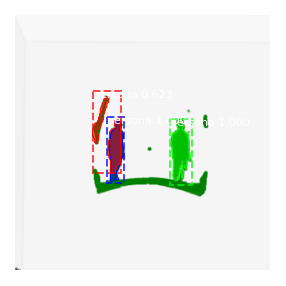

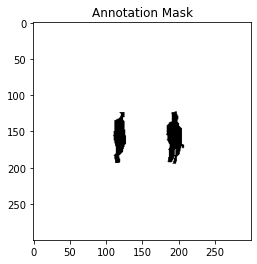

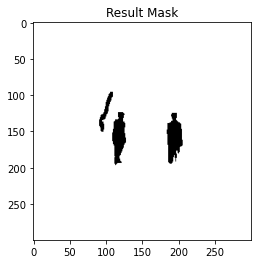

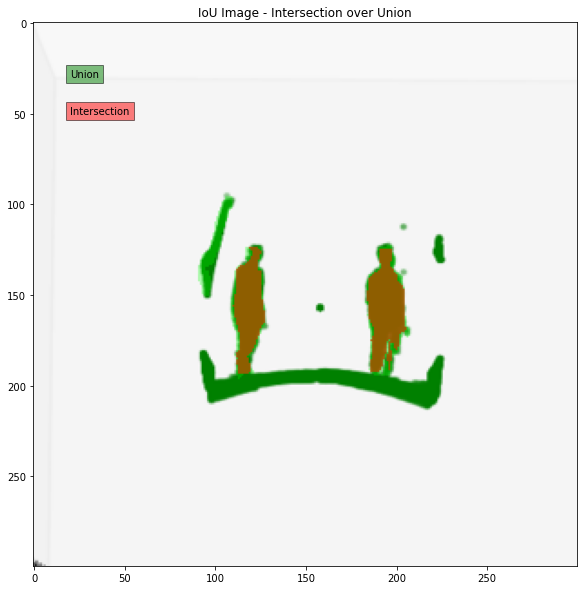

IoU: 0.7147022074135777
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


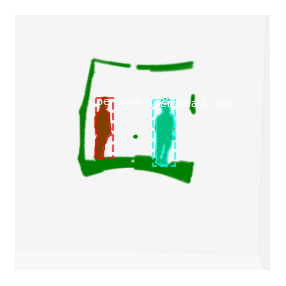

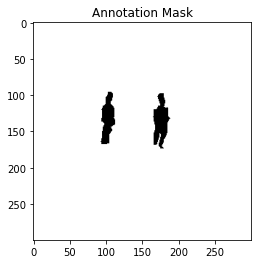

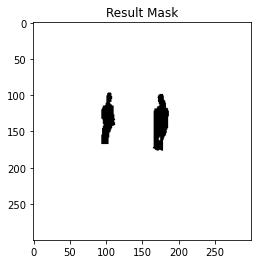

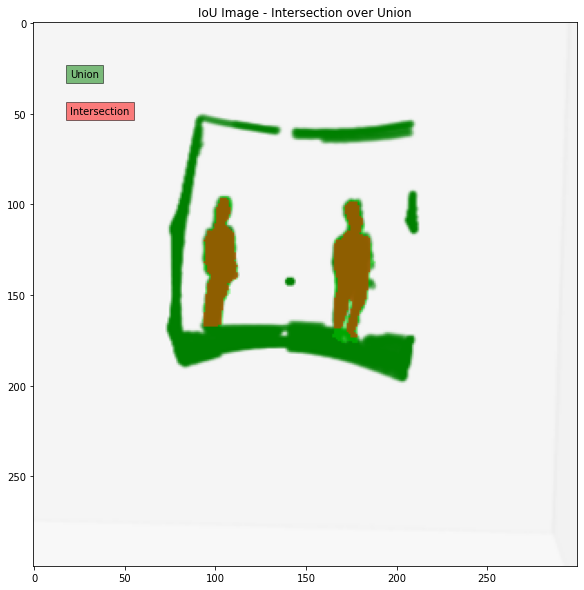

IoU: 0.8467220683287165
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


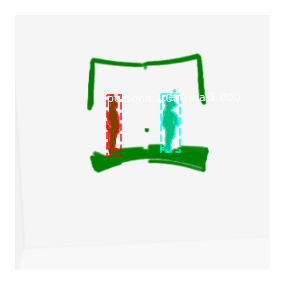

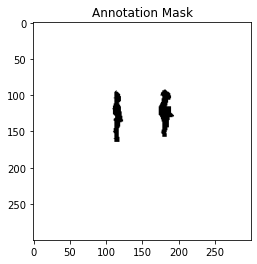

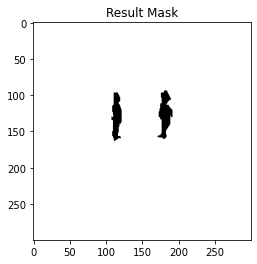

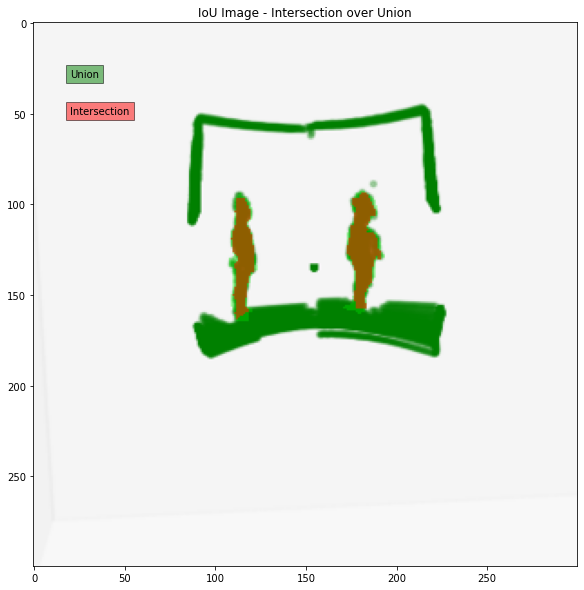

IoU: 0.7752590673575129
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


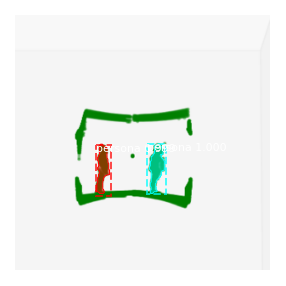

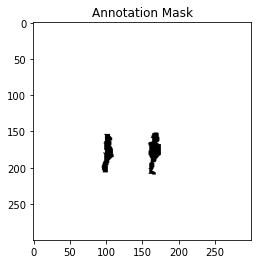

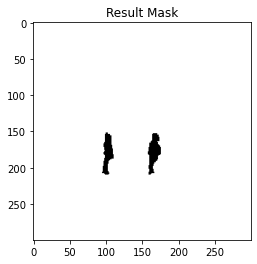

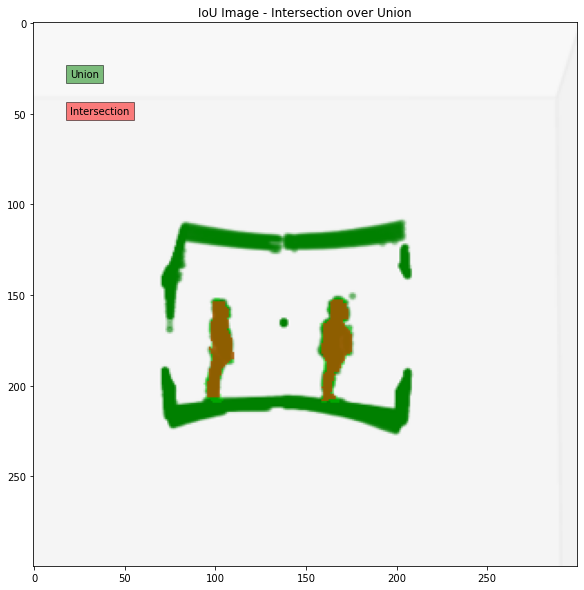

IoU: 0.8448415922014623
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


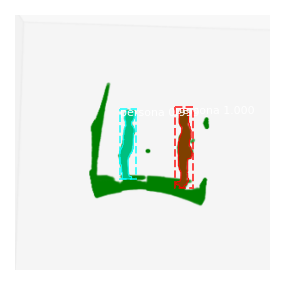

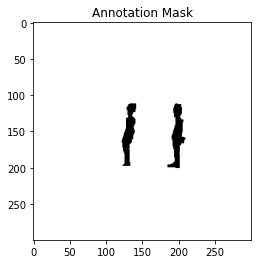

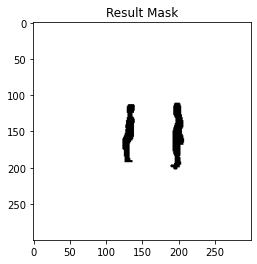

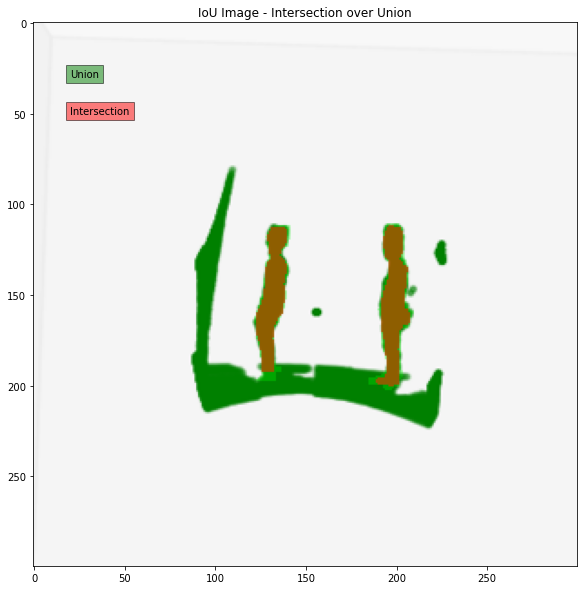

IoU: 0.827435773145904
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  251.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


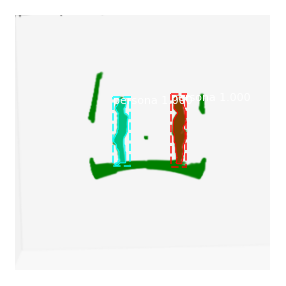

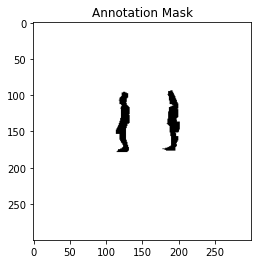

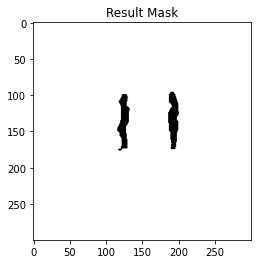

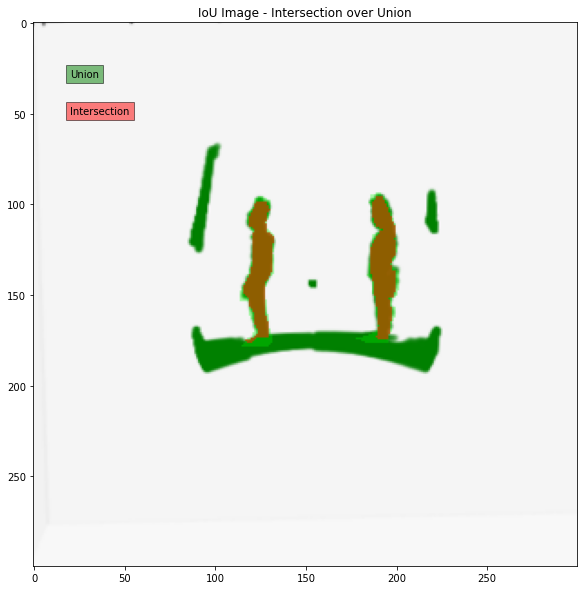

IoU: 0.7816864976720124
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


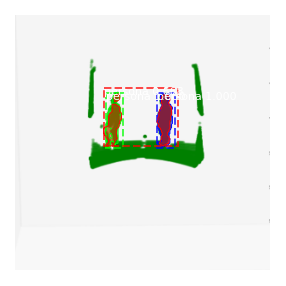

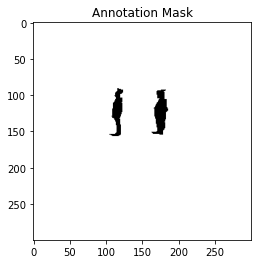

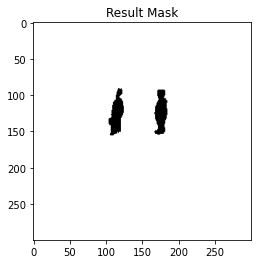

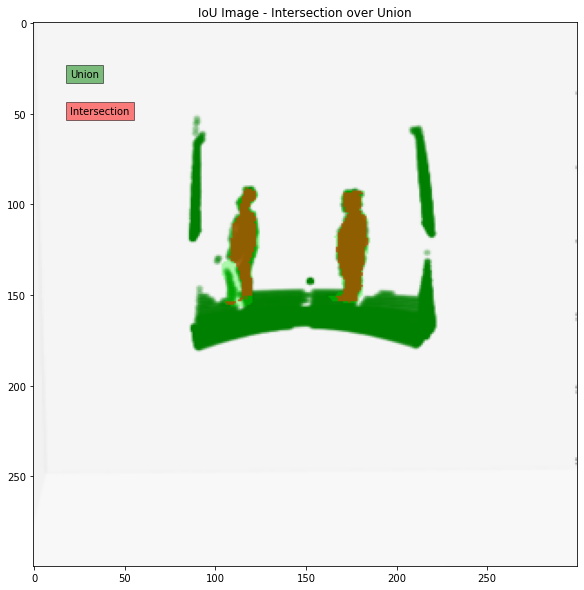

IoU: 0.740423098913665
Processing 1 images
image                    shape: (300, 300, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


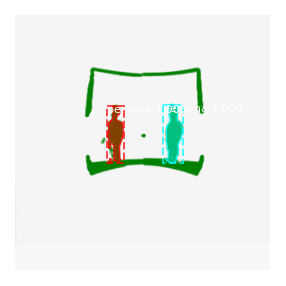

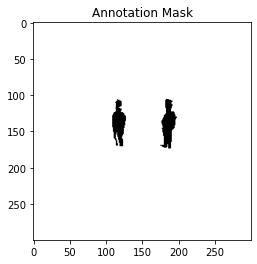

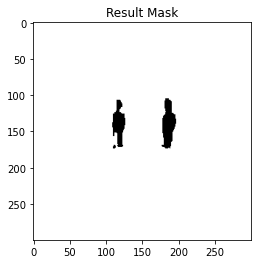

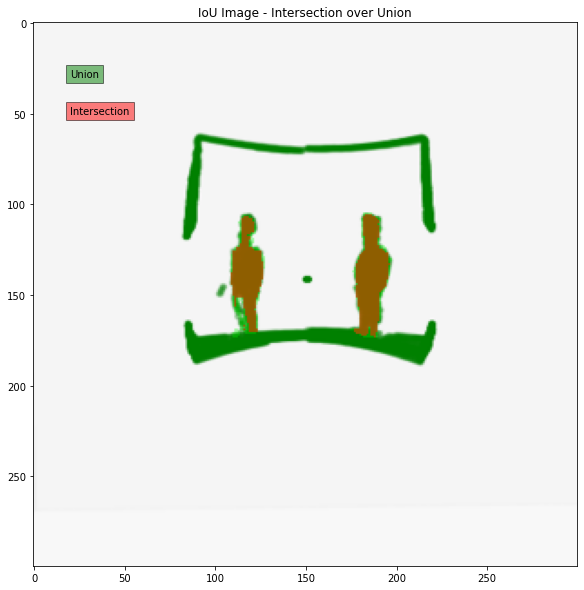

IoU: 0.8291713961407492


In [6]:
# Validation dataset
dataset = PersonaDataset()
dataset.load_personas("../semanticSegmentation/dataset/persona", "test")
dataset.prepare()

IoU_list = []


for image_id in dataset.image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    #visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    
    results = model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'], figsize=(5,5))

    IoU = IoU_function(mask, r['masks'])
    IoU_list.append(IoU)
    print('IoU:',IoU)
    
    

Number of Evaluations: 12
Average IoU:  0.7513061176525611
Standard Deviacion:  0.10991397226938283


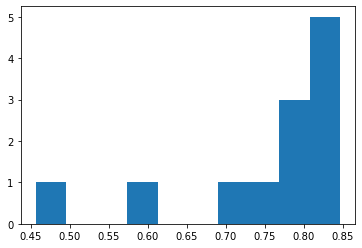

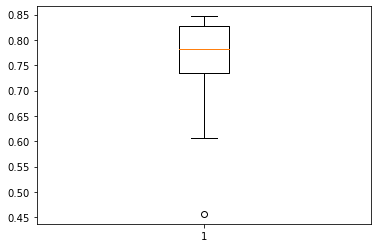

In [7]:
print('Number of Evaluations:', len(IoU_list))
print('Average IoU: ',np.mean(IoU_list))
print('Standard Deviacion: ', np.std(IoU_list))

plt.hist(IoU_list)
plt.show()

plt.boxplot(IoU_list)
plt.show()

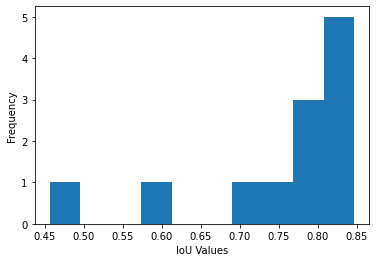

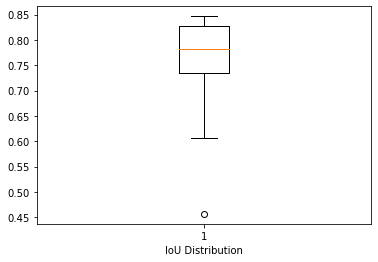

In [8]:
plt.hist(IoU_list)
plt.xlabel('IoU Values')
plt.ylabel('Frequency')
plt.show()

plt.boxplot(IoU_list)
plt.xlabel('IoU Distribution')
plt.show()



In [1]:
# -*- coding: utf-8 -*-
"""Casco.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1lc143a2R4knBq40FlbOXKECbZRa8M4oi
"""

import os
import numpy as np
import random
import colorsys
import cv2
from mrcnn.config import Config
from mrcnn import model as modellib


model_filename = "persona20230311T2329/mask_rcnn_persona_0050.h5"
class_names = ['BG', 'persona']
min_confidence = 0.6

camera = cv2.VideoCapture(0)
#camera = cv2.VideoCapture("video2.mp4")

class PersonaConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "persona"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (casco)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = PersonaConfig()
config.display()

class InferenceConfig(PersonaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    DETECTION_MIN_CONFIDENCE = min_confidence
    

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir='logs')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join('logs', model_filename)
#model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

  

while camera:
    ret, frame = camera.read()
    frame = cv2.resize(frame, (640, 480), interpolation = cv2.INTER_AREA)
    
    results = model.detect([frame], verbose=0)
    r = results[0]
    
    N =  r['rois'].shape[0]
    boxes=r['rois']
    masks=r['masks']
    class_ids=r['class_ids']
    scores=r['scores']
    
       
    hsv = [(i / N, 1, 0.7) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    
    random.shuffle(colors)
    #print("N_obj:",N)
    masked_image = frame.astype(np.uint32).copy()
    
    for i in range(N):
        
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue

        color = list(np.random.random(size=3) * 256)
        mask = masks[:, :, i]
        alpha=0.5

        
        for c in range(3):
            masked_image[:, :, c] = np.where(mask == 1,
                                  masked_image[:, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  masked_image[:, :, c])
            
        
        frame_obj=masked_image.astype(np.uint8)
        y1, x1, y2, x2 = boxes[i]
        cv2.rectangle(frame_obj, (x1, y1), (x2, y2),color, 2)  
        
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        label = class_names[class_id]
        caption = "{} {:.3f}".format(label, score) if score else label
        cv2.putText(frame_obj,caption,(int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        masked_image = frame_obj.astype(np.uint32).copy()
    
        
    if N>0:
        cv2.imshow('frame', frame_obj)
    else:
        cv2.imshow('frame', frame)
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break;
        
camera.release()
cv2.destroyAllWindows()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              